<font color='red'>Make sure you are using a dedicated virtual environment for Constellation.</font> For more info and to create one, see ds_measurement/setup.ipynb.


In [1]:
import sys  # using sys.executable forces installation in the active kernel
!{sys.executable} -m pip install --upgrade wfconstellation

Looking in indexes: https://artifactory-haproxy.service.intradsm1.consul.csnzoo.com:8099/artifactory/api/pypi/python/simple, https://artifactory-haproxy.service.intradsm1.consul.csnzoo.com:8099/artifactory/api/pypi/pypi-mirror/simple


In [37]:
from wfconstellation import gemini 
from wfconstellation.common_classes import TimeWindow
from wfconstellation.util import plot_comparisons
from wfconstellation.qa import QAConstellation

import numpy as np
import pandas as pd
import pandas_gbq
from datetime import date
from google.cloud import bigquery

In [38]:
import wfconstellation
print(wfconstellation.__version__)

0.3.40


## What's new in Gemini v7?

1. **Additional splitting algorithms that create more even groups:** There are 2 additional splitting options available, Palindromic v2 and Iterative Splitting, that decrease the relative difference of splits by up to 30% compared to the original method (developed with a former co-op on our team)
2. **Uneven splitting and stratified sampling options:** The additional algorithms  allow for uneven splits (e.g., 40/60 split) and a stratified sampling option (e.g., splitting units by class). The iterative splitting option can also allow for real-time splitting of units. 
3. **A/A power analysis feature** - Within eden-shared-nootebooks, there is a generalized A/A simulation function that allows users to understand the bias and minimum detectable lift for their tests 

## What is Gemini?

Gemini is an A/B testing framework designed for item-level tests (e.g., products, SKUs, URLs, classes) that creates 50/50 splits between groups and measures the treatment effect using a generalized estimating equation. Gemini has been used in tests for Paid Search (SEM-Intent, SEM-TOF, PLA), SEO, and Merch to measure treatment lifts for KPIs, such as visits, ATC, costs, revenue, and profit. To read more about the Gemini methodology, please see the [Infohub link](https://infohub.corp.wayfair.com/pages/viewpage.action?pageId=228066458) here. 

### **Design and Create Splits**

**Step 1: Create data table with 4 months of historical data** 
The first step in Gemini is to decide the units to randomize and the primary KPIs that need to be measured (up to 4-5 can be specified). To run the Gemini split, there must be at least 4 months of previous data for each unit and set of KPIs.  Gemini requires data at the daily level, so a table should be made containing daily KPI data for each unit that should be included in the test design. For example, if there are 100,000 units and 4 months of data, the table will be a maximum of 12M rows long (100,000 x 120 days), and there should be columns indicating the unit, date, and primary KPIs. It's easiest if these historical tables are produced and stored in GBQ.


**Step 2: Validate and Calibrate**
After creating the test splits, Gemini performs an A/A test using a generalized estimating equation (GEE) to ensure that there are no significant differences between groups during the validation period. The GEE model is used in the Measurement step as well (except data during the validation and test period will be used). 

Based on the parameters specified (e.g., quantile filter, number of subgroups), multiple designs can be run. Gemini will output the best design, depending on p-values and relative differences between groups. In general, we look to choose test splits that are relatively stable over the 4 months, appear equivalent during the training and validation period, and do not have large differences during peaks. 


### Step 1: Specify Design Parameters and Retrieve Test URL Table
#### **Important Notes about Gemini Designs**

1.   The input table must contain the final list of units that will be in the test! 
2.   It's recommended to generate a split 1-2 weeks before running the test. Gemini splits are usually stable for a maximum of 4-8 weeks.
3. This Python notebook assumes that there is a table in GBQ with units that will be used in the final test or that you will use a query to create a table. 
4. Design Level indicates which column you wish to design your test at. Gemini splits will be balanced across this Design Level. You also need to specify which level you will measure your results at. Often, the Design and Measurement level are the same. However, you can also design your test (e.g., at the class level) but measure at a different level (e.g., at keyword level).
5. You must fill out the parameter variables below for logging purposes. 


In [33]:
#parameter info which is saved for logging 
gemini_test_name = 'WFUS 5DoD Sales'
test_owner_email = 'jchen6@wayfair.com'
channelname = 'SEO' #options: PLA, SEM Intent, SEM ToF, Other
store_id = 49
num_test_group = 2
gemini_design_level = 'url'
gemini_measure_level = 'url'
KPI_cols =  ['Traffic', 'Clicks', 'Impressions','avgPosition']
date_column = 'day'
# 3-month training period
training_start_date = '2023-11-19'
training_end_date = '2024-02-19'
# 1-month validation period
validation_start_date = '2024-02-20'
validation_end_date = '2024-03-19'
# Expected Test Period
test_start_date = '2024-04-05'
test_end_date = '2024-04-09'
#Is this a Bidding 3.0 Test? This is only relevant for Athena Bidding Model tests. The default is False.
bidding_test = False
#bidding_test = True 
query_params = {'training_start_date': training_start_date, 'training_end_date': training_end_date, 'validation_start_date': validation_start_date, 'validation_end_date': validation_end_date, 'store_id': store_id}

In [34]:
%%bigquery df
SELECT * from `wf-gcp-us-ae-sf-prod.csn_junk.wfus_5dod_data_for_td`

Downloading: 100%|██████████| 1525315/1525315 [00:02<00:00, 560840.54rows/s] 


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525315 entries, 0 to 1525314
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   day          1525315 non-null  object 
 1   url          1525315 non-null  object 
 2   Traffic      1525315 non-null  int64  
 3   Clicks       688225 non-null   float64
 4   Impressions  688225 non-null   float64
 5   avgPosition  688225 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 69.8+ MB


In [36]:
df['day'] = pd.to_datetime(df['day'], format='%Y-%m-%d').dt.date
df['Traffic'] = df['Traffic'].astype('float32')


### Step 3: Run Gemini Split

### Example Creating Multiple Gemini Splits and Selecting the Best One
- **Recommended parameters to include:**
    - **data** - a dataframe that contains daily data with the units that will be included in the test and corresponding metrics
    - **metrics**: 
        - KPIs or features that the resulting units would be balanced over
        - We recommend using the KPIs that you plan to measure in the test, but it's also possible to add additional features.   
    - **unit_column**: 
        - column name for the units that will be assigned to treatment/control
    - **match_period**: 
        - a TimeWindow representing the start and end of a time window the interested metrics would match on
        - the match window is usually 3 months 
    - **date_column**: 
        - column name for dates
    - **split_ratios**: 
        - a list of floats for each group's share, should sum to 1
    - **validation_window**:
        - a TimeWindow for the validation window, which should be a recent period of time. We usually recommend using the last month as the validation window.  
    - **num_subgroup**: 
        - a list with number of subgroups to create in the design (per test group). **Constellation 0.3.30 update: We recommend using [5,10,15,20] subgroups by default. In some cases, if the best split is not satisfying, users may try other subgroup numbers outside of this range, e.g., try fewer subgroups when the number of product units are very small (<10000).**
    - **cutover_ranges**:
        - a list with the percentiles to consider excluding. If you wish to exclude outliers above a certain quantile threshold, indicate the quantiles to consider excluding. 0.005 would indicate that the top 0.5% of units in the test would be removed.
        
- **Optional parameters to include:**
    - **strata_col**: column name for a strata. This allows stratified sampling, which is a method of sampling that involves dividing a population into smaller groups. For example, if strata_col is 'class', units will be split within class (into treatment vs. control) and then combined to form the aggregate treatment and control groups. This is advantageous if the goal is to measure effects as class-level (rather than at an aggregate level). 

In [37]:
df.head()

day                                                url  Traffic  \
0  2023-12-21  https://www.wayfair.com/decor-pillows/sb2/extr...      1.0   
1  2023-12-21  https://www.wayfair.com/shop-office-spaces/sb0...      5.0   
2  2023-12-21  https://www.wayfair.com/bed-bath/sb1/waverly-b...      1.0   
3  2023-12-21  https://www.wayfair.com/furniture/sb2/swivel-w...      1.0   
4  2023-12-21  https://www.wayfair.com/shop-product-type/sb1/...      2.0   

   Clicks  Impressions  avgPosition  
0     NaN          NaN          NaN  
1     NaN          NaN          NaN  
2     NaN          NaN          NaN  
3     NaN          NaN          NaN  
4     NaN          NaN          NaN

In [38]:
x = gemini.TestDesign(data = df, 
                 metrics = KPI_cols, 
                 unit_column= gemini_design_level,
                 match_period= TimeWindow(training_start_date, training_end_date),
                 date_column= date_column,
                 split_ratios=[0.5, 0.5],
                 validation_window= TimeWindow(validation_start_date, validation_end_date))

In [39]:
min_key, dict_para2split, dict_subgroup_data, dict_para2diff = x.generate_split(
    cutover_ranges = [0.01, 0.03, 0.05], 
    subgroup_ranges = [5, 10, 15, 20], 
    methods = ['V1', 'V2']
)
best_split = dict_para2split[min_key]
best_key = min_key
final_gemini_design_data = dict_subgroup_data[min_key]

In [40]:
#what are all keys that exist in dict_para2split?
dict_para2split.keys()

dict_keys([('V1', 0.01, 5), ('V1', 0.01, 10), ('V1', 0.01, 15), ('V1', 0.01, 20), ('V1', 0.03, 5), ('V1', 0.03, 10), ('V1', 0.03, 15), ('V1', 0.03, 20), ('V1', 0.05, 5), ('V1', 0.05, 10), ('V1', 0.05, 15), ('V1', 0.05, 20), ('V2', 0.01, 5), ('V2', 0.01, 10), ('V2', 0.01, 15), ('V2', 0.01, 20), ('V2', 0.03, 5), ('V2', 0.03, 10), ('V2', 0.03, 15), ('V2', 0.03, 20), ('V2', 0.05, 5), ('V2', 0.05, 10), ('V2', 0.05, 15), ('V2', 0.05, 20)])

In [41]:
dict_subgroup_data[min_key]

day  TestGroup  SubGroup  Traffic  Clicks  Impressions  \
0     2023-11-01          0         0   2576.0  1156.0      26568.0   
1     2023-11-01          0         3   2607.0  1236.0      25061.0   
2     2023-11-01          0         4   2640.0  1323.0      30431.0   
3     2023-11-01          0         7   2626.0  1287.0      37142.0   
4     2023-11-01          0         8   2597.0  1291.0      36297.0   
...          ...        ...       ...      ...     ...          ...   
1415  2024-03-21          1         1   1114.0     0.0          0.0   
1416  2024-03-21          1         2   1104.0     0.0          0.0   
1417  2024-03-21          1         5   1054.0     0.0          0.0   
1418  2024-03-21          1         6   1129.0     0.0          0.0   
1419  2024-03-21          1         9   1154.0     0.0          0.0   

      avgPosition  
0     2608.313811  
1     2817.148331  
2     2664.423854  
3     2879.279776  
4     2710.333869  
...           ...  
1415     0.000000  
1416     0.000000  
1417     0.000000  
1418     0.000000  
1419     0.000000  

[1420 rows x 7 columns]

In [42]:
# Check whether any experimental units in your data were not assigned to a group.
# Possible reasons for units not being assigned to a group:
# - The parameter `cutover_ranges` removes some units from consideration (0.01 removes 1% of units)
# - Even if `cutover_ranges` is 0:
# -- if the total number of units is not evenly divisible by the total number of subgroups (i.e., `subgroup_ranges` * number of groups),
# -- then the remaining units will not be assigned to a group (b/c number of units in each subgroup must be equal).
# - If the sum of KPIs during the design period for a given unit is 0, that unit may not be assigned to a group.
qa_design = QAConstellation.from_design_object(x)
unassigned_units = qa_design.check_unassigned_units()
percent_unassigned = 100 * len(unassigned_units) / len(qa_design.exp_unit_time_series[qa_design.unit_column].unique())
print(f"\nPercent of units not assigned to an experimental group: {percent_unassigned:.2f}%")

split_result defaulting to split result from design object.
319 units were not assigned to an experimental group.
KPIs with sums of 0 during design period may cause units to not be assigned.

Percent of units not assigned to an experimental group: 1.02%


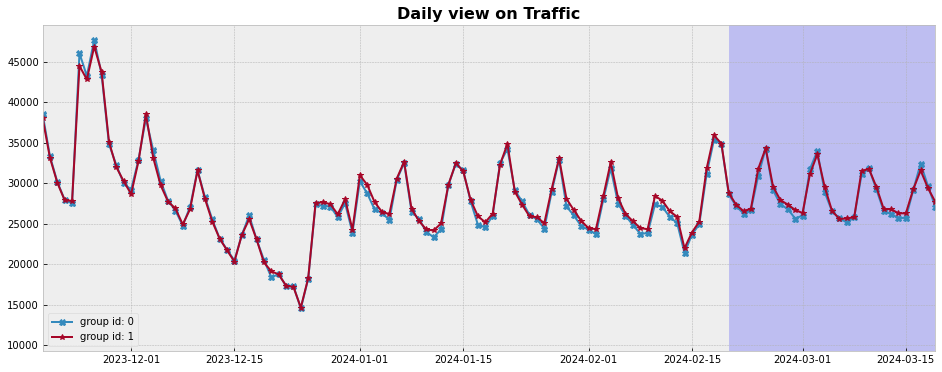

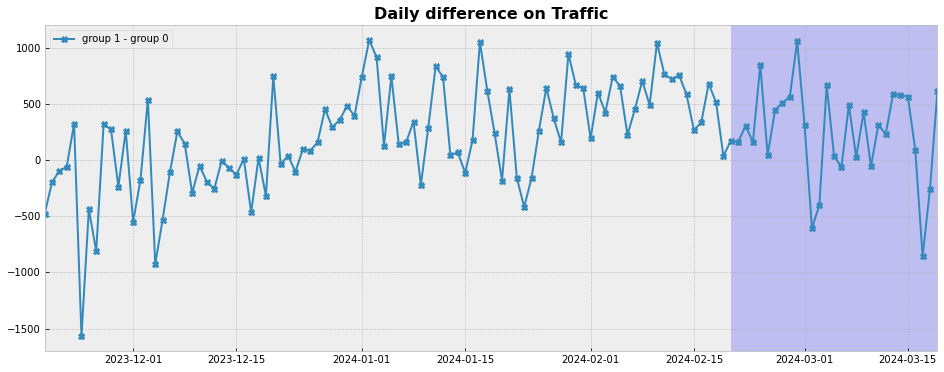

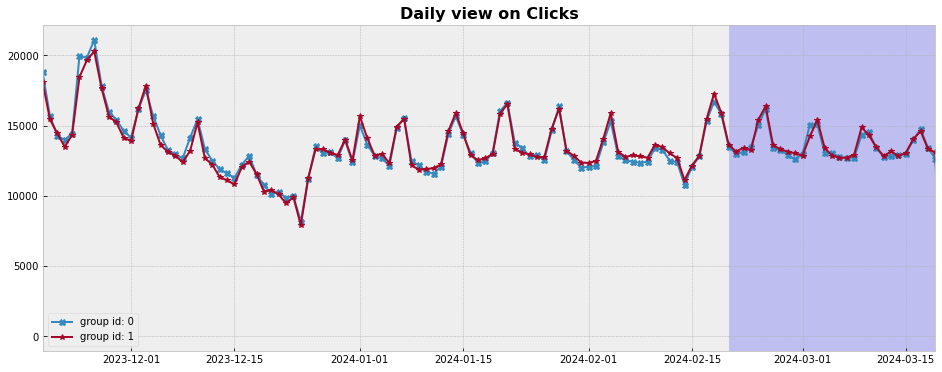

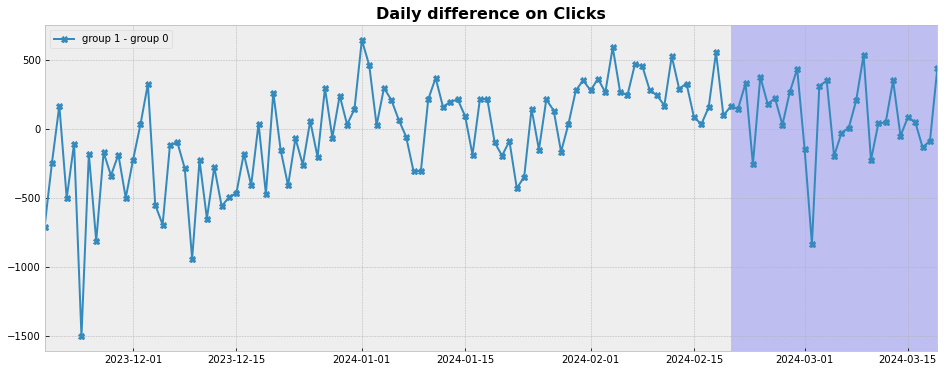

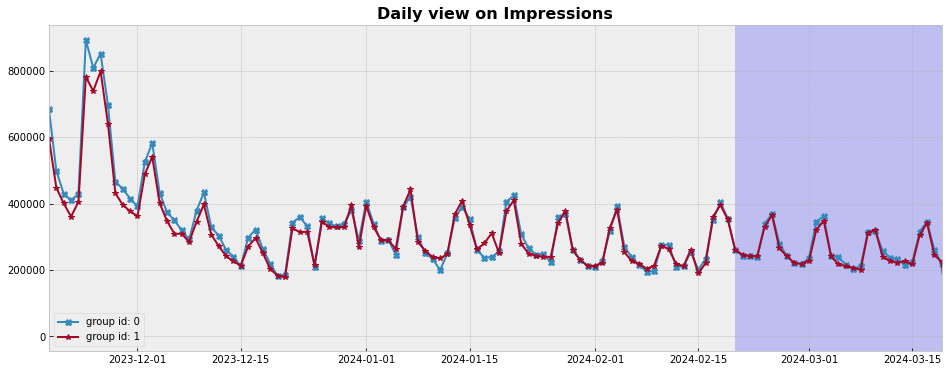

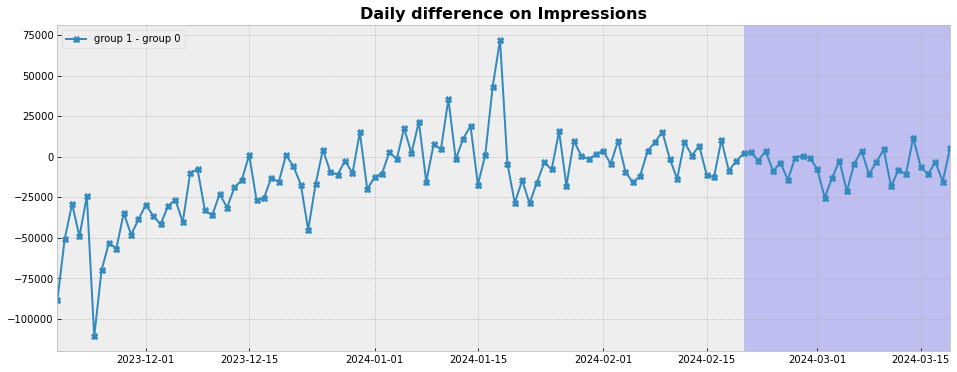

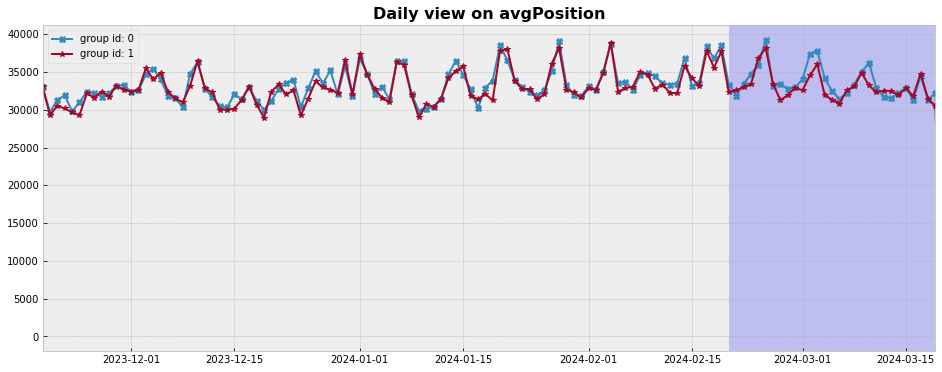

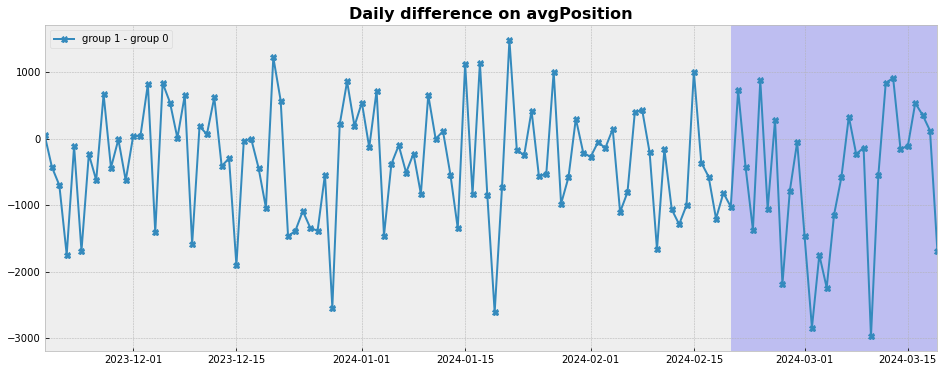

In [43]:
plot_comparisons(daily_data=final_gemini_design_data, 
                metrics=KPI_cols, 
                group_column = 'TestGroup', 
                date_column = date_column,
                group_ids=[0, 1], 
                group_ratios=[0.5, 0.5], 
                time_range=[training_start_date, validation_end_date], 
                shade_window=[validation_start_date, validation_end_date], 
                include_diff=True)

### Check whether the difference between groups is statistically significant at baseline

#### **If some of the KPIs are too imbalanced, we recommend removing some of the metrics that are not primary KPIs. Sometimes including too many metrics can result in an overall greater imbalance in the metrics. To do this, change the KPI_cols list right before Step 3.**

### Use 'compute_lift' to pull the Validation Read to check whether the groups have no sig. differences
- The output will be the daily average of the control group (test_control) and treatment group (test_treatment) *at the subgroup level*, as well as the daily difference between the groups (measurement lift) *at the subgroup level* and a confidence interval*
- In addition, a p-value is provided and the lift ratio (measured lift/test_control). 
- If the p-value is less than 0.10, you can assume that there is less than a 10% chance to observe this effect under the null hypothesis (i.e., the null hypothesis assumes that there is no effect). A p-value threshold of 0.05 or 0.10 is often standard to assume a significant effect.

In [44]:
y = gemini.TestMeasure(data = final_gemini_design_data, 
                       metrics = KPI_cols, 
                       test_window = TimeWindow(validation_start_date, validation_end_date), 
                       assignment_column = 'TestGroup', 
                       subgroup_column = 'SubGroup',
                       date_column = date_column, 
                       group_names = {'control': 0, 'treatment': 1},
                       split_ratios = {'control': 0.5, 'treatment': 0.5})
y.measure_lift(method = 'gemini_v5')

Group_0_daily_average  Group_1_daily_average      Scale  \
Traffic               14171.068966           14290.724138  treatment   
Clicks                 6769.517241            6816.000000  treatment   
Impressions          131805.000000          129104.896552  treatment   
avgPosition           16815.032458           16507.920574  treatment   

             Group_0_daily_average_scaled  Group_1_daily_average_scaled  \
Traffic                      14171.068966                  14290.724138   
Clicks                        6769.517241                   6816.000000   
Impressions                 131805.000000                 129104.896552   
avgPosition                  16815.032458                  16507.920574   

             Daily_lift_scaled                              Daily_lift_CI  \
Traffic             119.655172  (-108.55247691322985, 347.86282174081543)   
Clicks               46.482759   (-149.52438258791267, 242.4898998292917)   
Impressions       -2700.103448   (-7285.504224129609, 1885.2973275778857)   
avgPosition        -307.111884    (-741.6576664461747, 127.4338984262026)   

              P_value  Lift_ratio  Cumulative_lift_scaled  \
Traffic      0.388446    0.008444             3470.000000   
Clicks       0.696482    0.006866             1348.000000   
Impressions  0.332761   -0.020486           -78303.000000   
avgPosition  0.245037   -0.018264            -8906.244636   

                                   Cumulative_lift_CI Test_duration  \
Traffic      (-3148.021830483666, 10088.021830483647)            29   
Clicks        (-4336.207095049467, 7032.207095049459)            29   
Impressions  (-211279.62249975864, 54673.62249975868)            29   
avgPosition  (-21508.07232693907, 3695.5830543598754)            29   

             Confidence_level  
Traffic                   0.9  
Clicks                    0.9  
Impressions               0.9  
avgPosition               0.9

## Another option: Save table in GBQ with test splits 

In [46]:
# Use a project that you have permission to write to
pandas_gbq.to_gbq(
    best_split, 'analysis_seo.wfus_5dod_test_split', project_id='wf-gcp-us-ae-mktg-prod', if_exists='replace',
)

100%|██████████| 1/1 [00:00<00:00, 9686.61it/s]


# Gemini Measurement after the test launches

- For any pair of (treatment, control), use function __measure_lift__ to compute the incrementality.
- **Mandatory parameters to include:**
    - **data**: pd.DataFrame storing daily level metrics for each subgroup
    - **metrics**: list with metric names
    - **test_window**: TimeWindow, for the measurement period
        

- **Optional parameters to include:**
    - **pretest_window**: TimeWindow, for the prior test period
    - **assignment_column**: string for the name of assignment column
                        default value: "TestGroup"
    - **subgroup_column**: string for the name of subgroup column
                        default value: "SubGroup"
    - **date_column**: string for the name of date column
                        default value: "date"
    - **conf_level**: float, confidence level, default: 0.9
    - **tail**: int, 1 for single tail and 2 for two-tail
    - **split_ratios**: dictionary containing group shares for the two groups to use for measurement. Should be specified as: {'control': \<control group share\>, 'treatment': \<treatment group share\>}, where lift is interpreted as how treatment changed relative to control.
    - **group_names**: dictionary containing group ids for the two groups to use for measurement. Should be specified as: {'control': \<control group name\>, 'treatment': \<treatment group name\>}, where lift is interpreted as how treatment changed relative to control. default value: {'control': 0, 'treatment': 1}
    - **scale_to**: options are 'full-scale', 'treatment', 'control' (default: 'treatment'). 'treatment' will report lift values on the observed data scale (i.e., the actual amount of lift for the treatment group); 'full-scale' will scale the lift to represent the total opportunity represented by this treatment - the lift that we WOULD EXPECT if we were to apply the treatment to the entire sample, rather than just the proportion of the sample contained in the treatment group; 'control' will scale the data to the control group, which is not typically needed.
    
**There is also an option to adjust for the pre-calibration time period using the 'pretest_window' parameter .** The Calibrated version accounts for the period between designing the test and launching the test, so helps to offset an initial imbalance between the groups. This is also important for the measurement of secondary KPIs, which were not used in the initial test design. 

In [63]:
# validation period
validation_start_date = '2024-02-02'
validation_end_date = '2024-03-19'
# test period
test_start_date = '2024-04-05'
test_end_date = '2024-04-09'
KPI_measurement_cols = ['Visits','PDP','ATC','Converted','Bounced','Acquisitions','PDP_Rate','ATC_Rate','Conversion_Rate','Bounce_Rate','Acquisition_Rate',
                        'unique_keywords','Impressions','Ranks','Clicks','CTR',
                        'GRS','AOV','GRS_Themis','Orders_Themis','AOV_Themis']

date_column_meas = 'sessionstartdate'

measurement_query_params = {'validation_start_date': validation_start_date, 'validation_end_date': validation_end_date, 'test_start_date': test_start_date, 'test_end_date': test_end_date}

In [64]:
%%bigquery measurement_df
SELECT * from  `wf-gcp-us-ae-sf-prod.csn_junk.wfus_5dod_kpis_TR`

Downloading: 100%|██████████| 500/500 [00:02<00:00, 248.76rows/s]


In [65]:
measurement_df.head(5)

sessionstartdate  testgroup  subgroup  Visits   PDP  ATC  Converted  \
0       2024-02-20          0         7    2712  1315  146         27   
1       2024-02-20          0         8    2902  1428  173         27   
2       2024-02-20          1         1    2811  1360  164         25   
3       2024-02-20          0         4    2916  1442  149         36   
4       2024-02-20          0         0    2826  1375  170         31   

   Bounced  Acquisitions  PDP_Rate  ...  Impressions     Ranks  avg_position  \
0     1041            15  0.484882  ...        24314  7.269692      6.915364   
1     1092            12  0.492074  ...        26773  7.060796      6.900372   
2     1068            10  0.483814  ...        24494  7.413203      6.895630   
3     1062            14  0.494513  ...        27603  6.754353      6.670376   
4     1067             7  0.486553  ...        25346  7.916827      7.149784   

   Clicks       CTR             GRS            AOV      GRS_Themis  \
0    1241  0.051041  9361.510000000  346.722592593  4384.221098605   
1    1429  0.053375  6724.240000000  249.045925926  6188.987116701   
2    1314  0.053646  4447.140000000  177.885600000  3923.691988543   
3    1366  0.049487  8387.730000000  232.992500000  5641.390675000   
4    1297  0.051172  7789.790000000  251.283548387  5930.255318242   

   Orders_Themis  AOV_Themis  
0      15.198013  288.473303  
1      16.356216  378.387475  
2      14.321273  273.976478  
3      18.390899  306.749050  
4      15.982357  371.050106  

[5 rows x 25 columns]

In [66]:
measurement_df.dtypes

sessionstartdate     object
testgroup             int64
subgroup              int64
Visits                int64
PDP                   int64
ATC                   int64
Converted             int64
Bounced               int64
Acquisitions          int64
PDP_Rate            float64
ATC_Rate            float64
Conversion_Rate     float64
Bounce_Rate         float64
Acquisition_Rate    float64
unique_keywords       int64
Impressions           int64
Ranks               float64
avg_position        float64
Clicks                int64
CTR                 float64
GRS                  object
AOV                  object
GRS_Themis           object
Orders_Themis       float64
AOV_Themis          float64
dtype: object

In [67]:
measurement_df['GRS'] = measurement_df['GRS'].astype('float32')
measurement_df['AOV'] = measurement_df['AOV'].astype('float32')
measurement_df['GRS_Themis'] = measurement_df['GRS_Themis'].astype('float32')
measurement_df['testgroup'] = measurement_df['testgroup'].astype('float32')
measurement_df['subgroup'] = measurement_df['subgroup'].astype('float32')
measurement_df['Visits'] = measurement_df['Visits'].astype('float32')
measurement_df['PDP'] = measurement_df['PDP'].astype('float32')
measurement_df['ATC'] = measurement_df['ATC'].astype('float32')
measurement_df['Converted'] = measurement_df['Converted'].astype('float32')
measurement_df['Bounced'] = measurement_df['Bounced'].astype('float32')
measurement_df['Acquisitions'] = measurement_df['Acquisitions'].astype('float32')
measurement_df['Acquisitions'] = measurement_df['Acquisitions'].astype('float32')

### Use 'measurement_lift' to pull Measurement Test Read (adjusting for pre-test window)
- The output will be the daily average of the control group (test_control) and treatment group (test_treatment) *at the subgroup level*, as well as the daily difference between the groups (measurement lift) *at the subgroup level* and a confidence interval*
- In addition, a p-value is provided and the lift ratio (measured lift/test_control). 
- If the p-value is less than 0.10, you can assume that there is less than a 10% chance to observe this effect under the null hypothesis (i.e., the null hypothesis assumes that there is no effect). A p-value threshold of 0.05 or 0.10 is often standard to assume a significant effect.

**This example adjusts for the pre-calibration time period using the 'pretest_window' parameter.** The Calibrated version accounts for the period between designing the test and launching the test, so helps to offset an initial imbalance between the groups. This is also important for the measurement of secondary KPIs, which were not used in the initial test design. 

In [68]:
measurement_df

sessionstartdate  testgroup  subgroup  Visits   PDP  ATC  Converted  \
0         2024-02-20          0         7    2712  1315  146         27   
1         2024-02-20          0         8    2902  1428  173         27   
2         2024-02-20          1         1    2811  1360  164         25   
3         2024-02-20          0         4    2916  1442  149         36   
4         2024-02-20          0         0    2826  1375  170         31   
..               ...        ...       ...     ...   ...  ...        ...   
495       2024-04-09          0         7    2572  1181  150         28   
496       2024-04-09          0         4    2624  1186  123         24   
497       2024-04-09          1         5    2616  1256  154         27   
498       2024-04-09          1         6    2674  1215  151         30   
499       2024-04-09          0         0    2901  1262  157         26   

     Bounced  Acquisitions  PDP_Rate  ...  Impressions     Ranks  \
0       1041            15  0.484882  ...        24314  7.269692   
1       1092            12  0.492074  ...        26773  7.060796   
2       1068            10  0.483814  ...        24494  7.413203   
3       1062            14  0.494513  ...        27603  6.754353   
4       1067             7  0.486553  ...        25346  7.916827   
..       ...           ...       ...  ...          ...       ...   
495     1046            11  0.459176  ...        37005  8.171134   
496     1023            13  0.451982  ...        40062  8.373519   
497      994            11  0.480122  ...        35161  7.679861   
498     1060            15  0.454375  ...        39643  7.836294   
499     1193            10  0.435022  ...        49275  7.336315   

     avg_position  Clicks       CTR           GRS         AOV   GRS_Themis  \
0        6.915364    1241  0.051041   9361.509766  346.722595  4384.221191   
1        6.900372    1429  0.053375   6724.240234  249.045929  6188.987305   
2        6.895630    1314  0.053646   4447.140137  177.885605  3923.691895   
3        6.670376    1366  0.049487   8387.730469  232.992493  5641.390625   
4        7.149784    1297  0.051172   7789.790039  251.283554  5930.255371   
..            ...     ...       ...           ...         ...          ...   
495      8.472626    1204  0.032536  12816.679688  457.738586  4036.084717   
496      7.577282    1222  0.030503   8599.809570  358.325409  6489.808105   
497      8.067338    1219  0.034669   6852.259766  253.787415  3815.621826   
498      8.151733    1272  0.032086   6970.000000  232.333328  8159.252441   
499      8.085263    1339  0.027174   6581.419922  253.131546  6248.687988   

     Orders_Themis  AOV_Themis  
0        15.198013  288.473303  
1        16.356216  378.387475  
2        14.321273  273.976478  
3        18.390899  306.749050  
4        15.982357  371.050106  
..             ...         ...  
495      11.502021  350.902222  
496      14.748964  440.017888  
497      12.560399  303.781885  
498      14.189748  575.010401  
499      17.698121  353.070691  

[500 rows x 25 columns]

In [69]:
y = gemini.TestMeasure(data = measurement_df, 
                       metrics = KPI_measurement_cols, 
                       test_window = TimeWindow(test_start_date, test_end_date),
                       pretest_window = TimeWindow(validation_start_date, validation_end_date),
                       assignment_column = 'testgroup', 
                       subgroup_column = 'subgroup',
                       date_column = date_column_meas, 
                       group_names = {'control': 0, 'treatment': 1},
                       split_ratios = {'control': 0.5, 'treatment': 0.5})
calibrated_read = y.measure_lift()
calibrated_read

/opt/conda/lib/python3.7/site-packages/wfconstellation/common_classes.py:426: UserWarning: Data provided starts after the beginning of the TimeWindow: Timewindow starts on 2024-02-02, earliest date in data is 2024-02-20.
  + "."


Group_0_daily_average  Group_1_daily_average      Scale  \
Visits                     13311.200000           13421.200000  treatment   
PDP                         6053.400000            6229.200000  treatment   
ATC                          759.800000             762.600000  treatment   
Converted                    141.400000             146.600000  treatment   
Bounced                     5231.400000            5192.600000  treatment   
Acquisitions                  55.400000              51.600000  treatment   
PDP_Rate                       2.271707               2.316916  treatment   
ATC_Rate                       0.284521               0.283132  treatment   
Conversion_Rate                0.053031               0.054291  treatment   
Bounce_Rate                    1.967498               1.938454  treatment   
Acquisition_Rate               0.020982               0.019127  treatment   
unique_keywords             5206.200000            5302.000000  treatment   
Impressions               142290.000000          143420.800000  treatment   
Ranks                         42.809724              40.906529  treatment   
Clicks                      6374.400000            6571.800000  treatment   
CTR                            0.239111               0.242828  treatment   
GRS                        39305.707715           40927.097949  treatment   
AOV                         1393.850110            1411.287827  treatment   
GRS_Themis                 24862.599609           26347.734375  treatment   
Orders_Themis                 74.146568              73.662409  treatment   
AOV_Themis                  1667.216655            1761.360218  treatment   

                  Group_0_daily_average_scaled  Group_1_daily_average_scaled  \
Visits                            13311.200000                  13421.200000   
PDP                                6053.400000                   6229.200000   
ATC                                 759.800000                    762.600000   
Converted                           141.400000                    146.600000   
Bounced                            5231.400000                   5192.600000   
Acquisitions                         55.400000                     51.600000   
PDP_Rate                              2.271707                      2.316916   
ATC_Rate                              0.284521                      0.283132   
Conversion_Rate                       0.053031                      0.054291   
Bounce_Rate                           1.967498                      1.938454   
Acquisition_Rate                      0.020982                      0.019127   
unique_keywords                    5206.200000                   5302.000000   
Impressions                      142290.000000                 143420.800000   
Ranks                                42.809724                     40.906529   
Clicks                             6374.400000                   6571.800000   
CTR                                   0.239111                      0.242828   
GRS                               39305.707715                  40927.097949   
AOV                                1393.850110                   1411.287827   
GRS_Themis                        24862.599609                  26347.734375   
Orders_Themis                        74.146568                     73.662409   
AOV_Themis                         1667.216655                   1761.360218   

                  Daily_lift_scaled  \
Visits                    28.723404   
PDP                      133.565957   
ATC                       -0.200000   
Converted                  5.561702   
Bounced                  -62.353191   
Acquisitions              -4.970213   
PDP_Rate                   0.043624   
ATC_Rate                  -0.000759   
Conversion_Rate            0.001702   
Bounce_Rate               -0.026442   
Acquisition_Rate          -0.002154   
unique_keywords           61.693617   
Impressions             2659.289362   
Ranks           

### Visualize measurement data

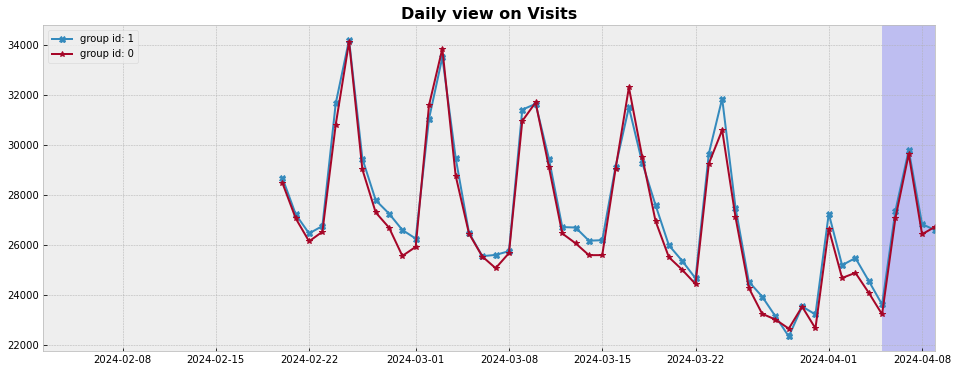

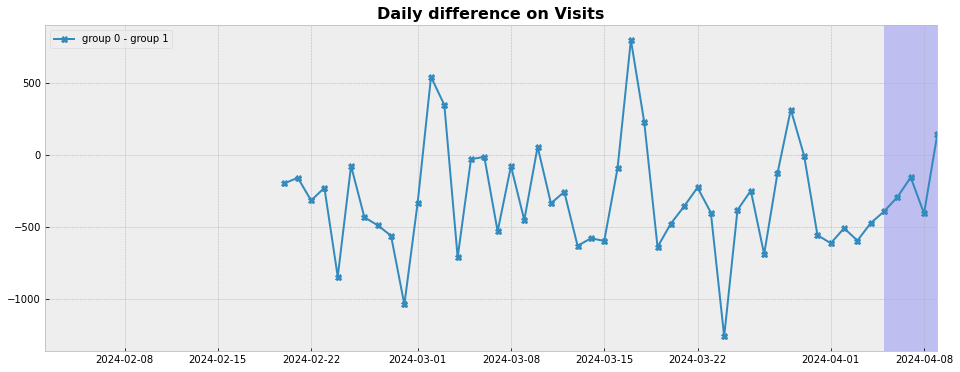

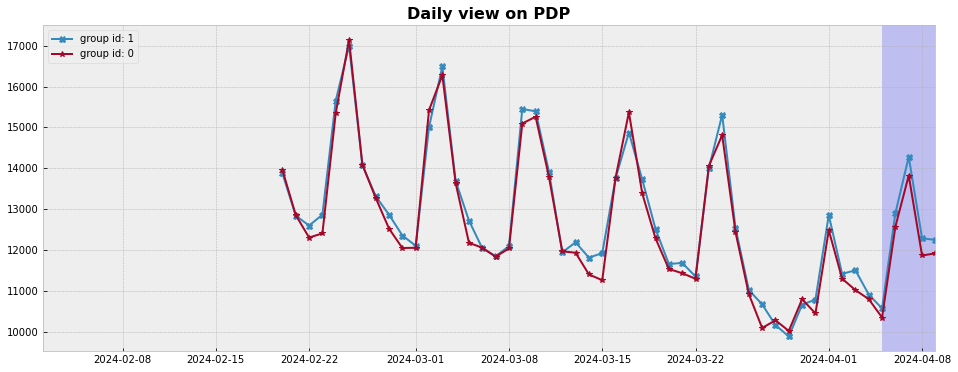

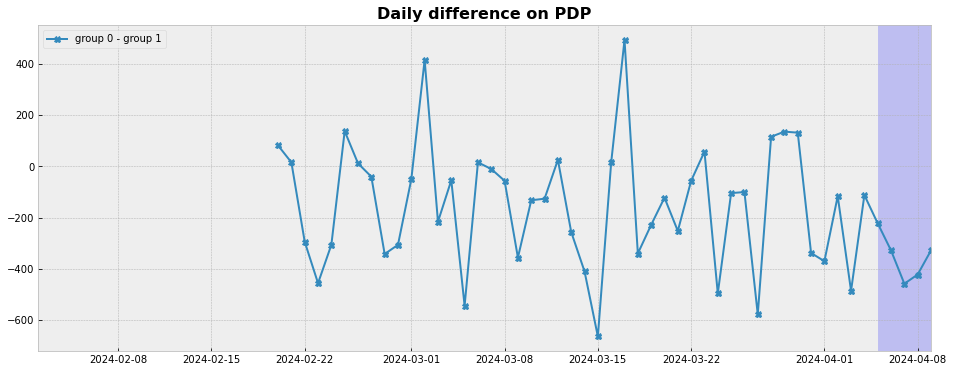

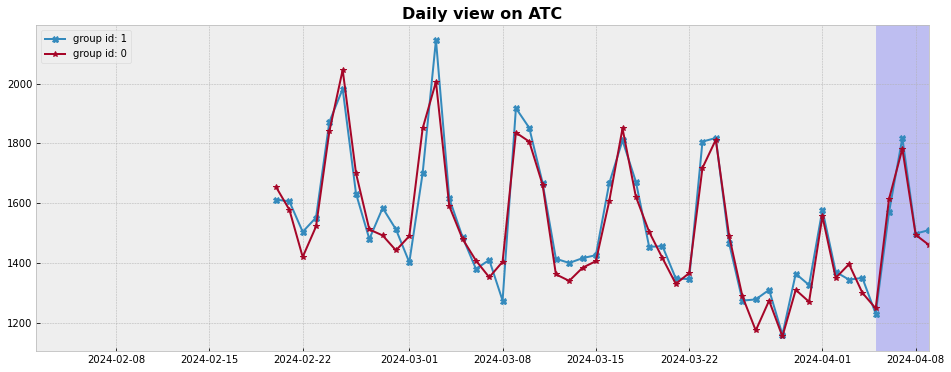

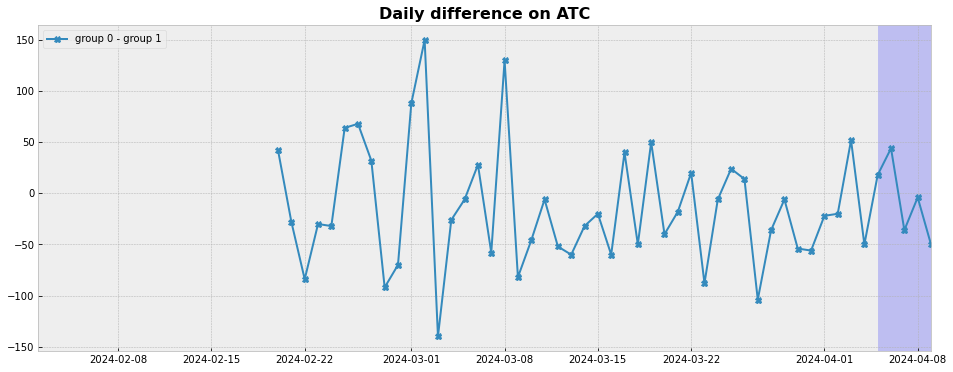

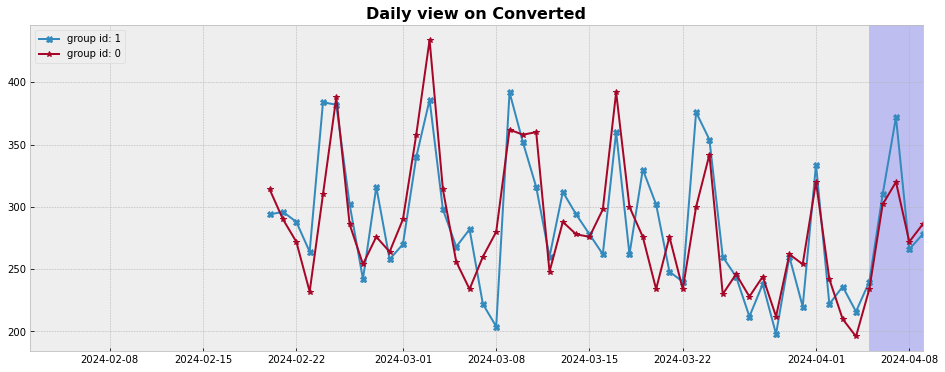

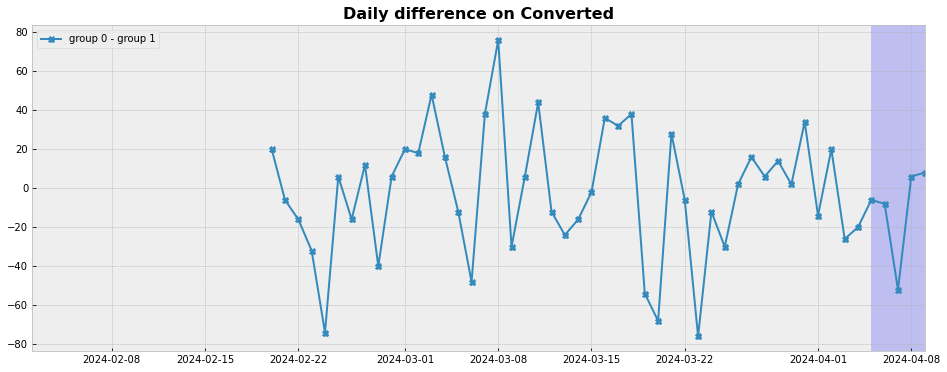

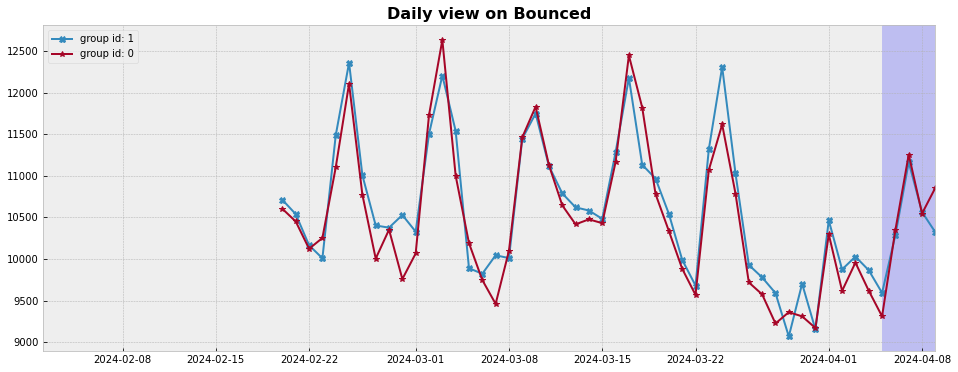

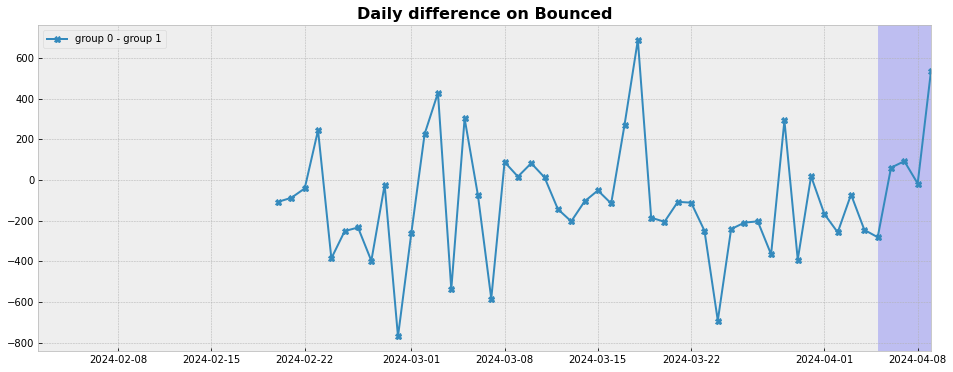

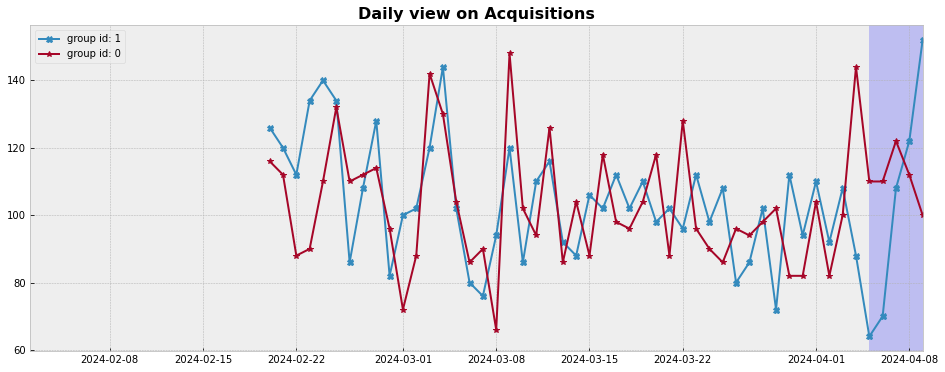

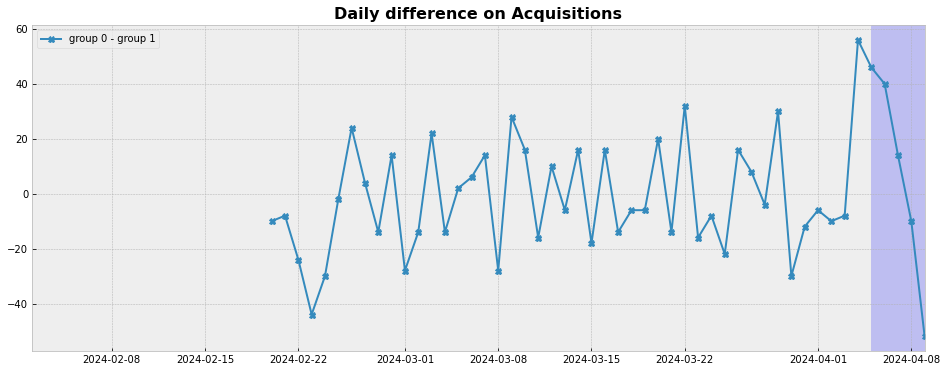

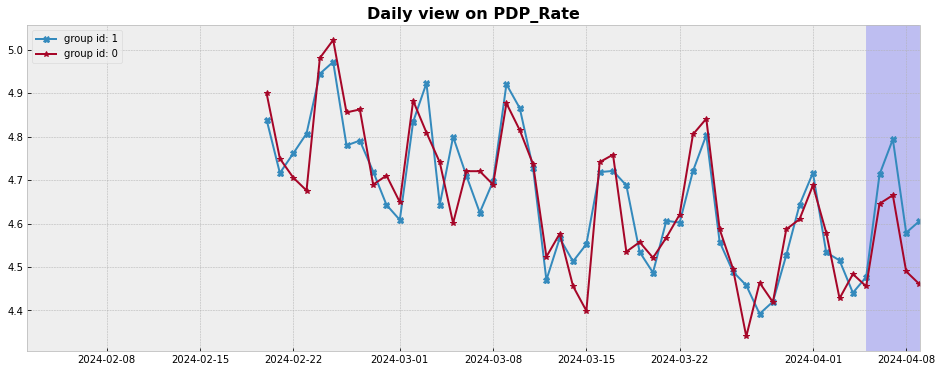

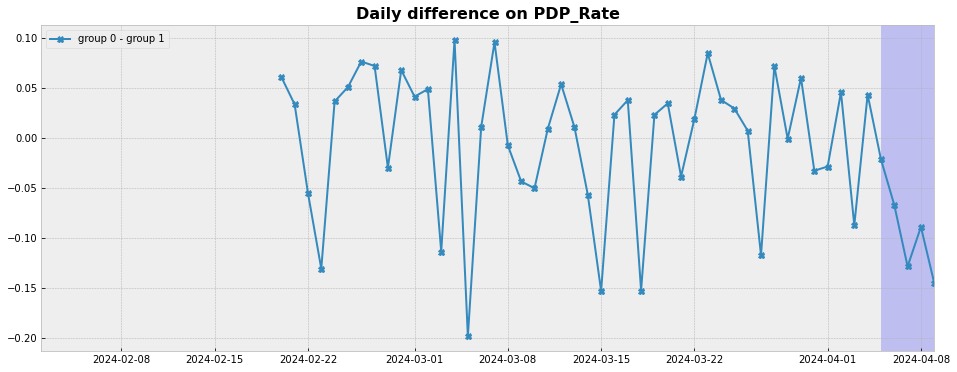

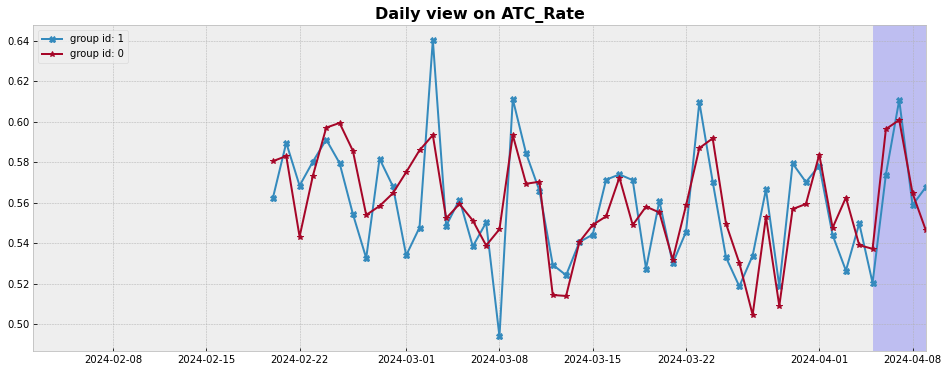

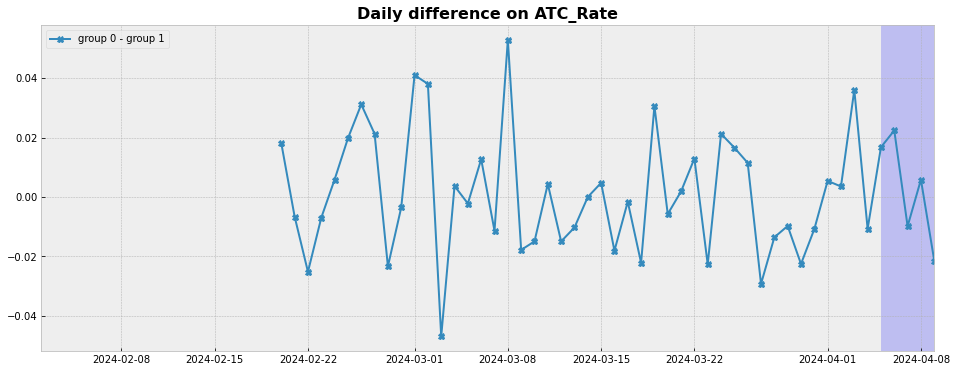

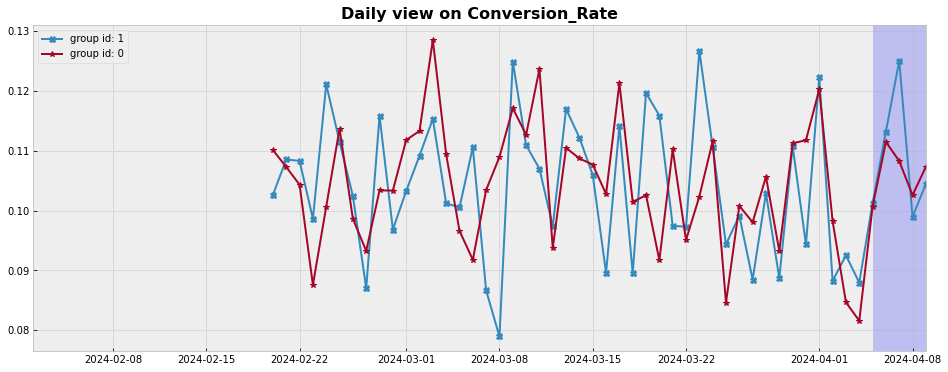

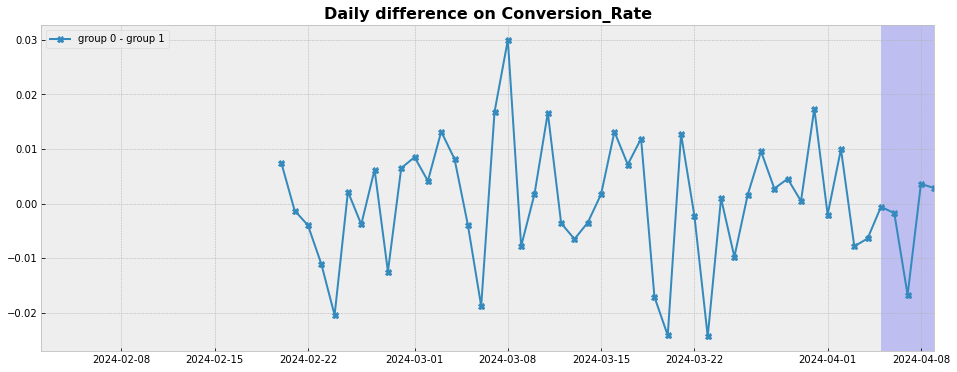

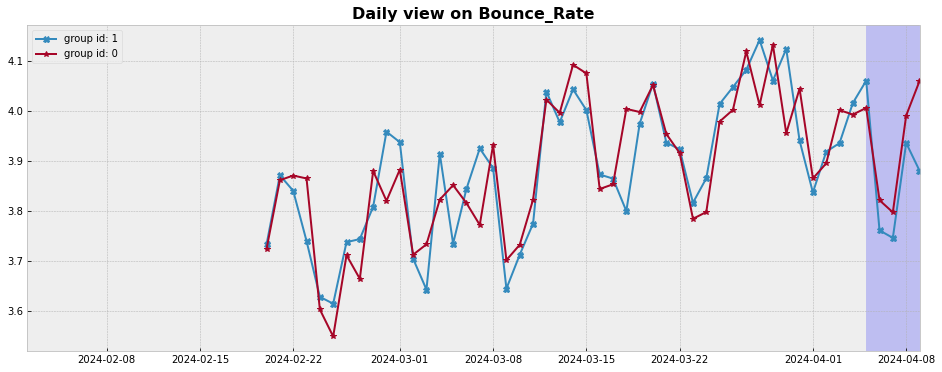

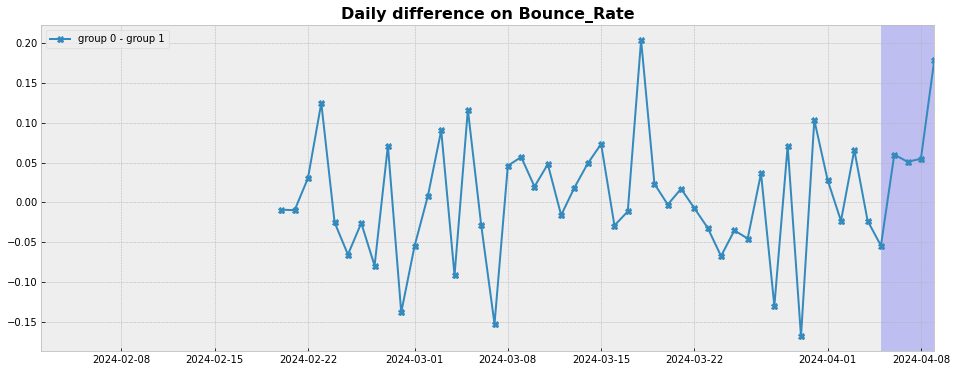

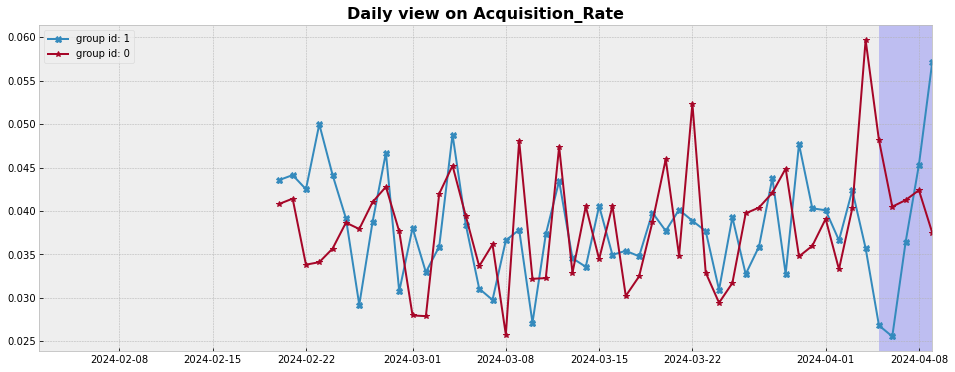

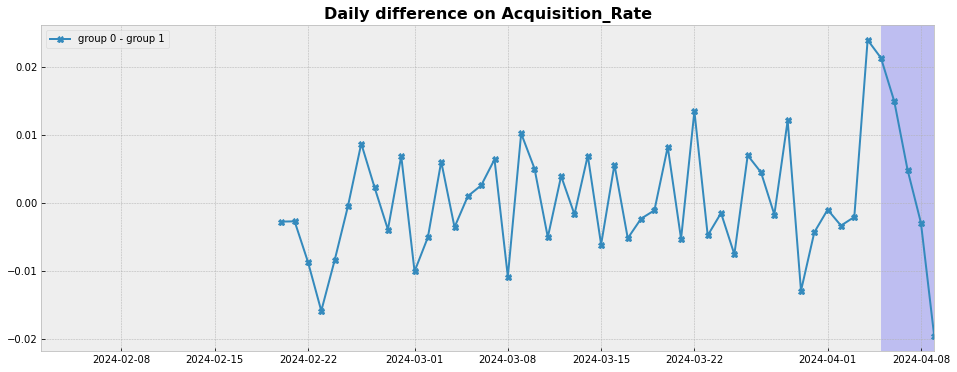

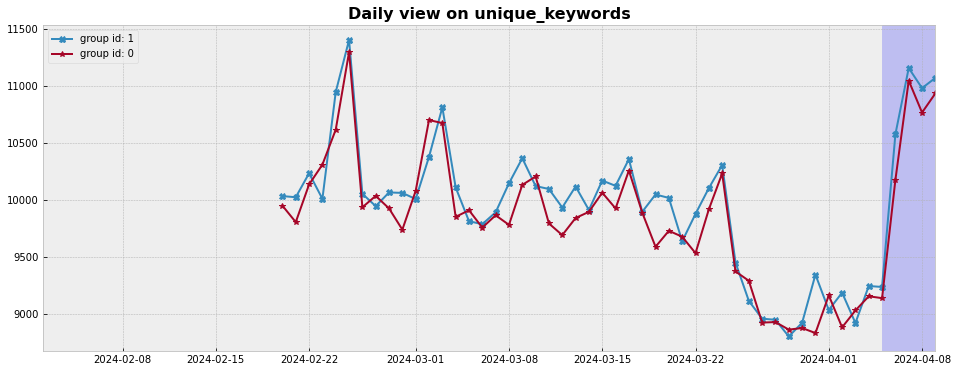

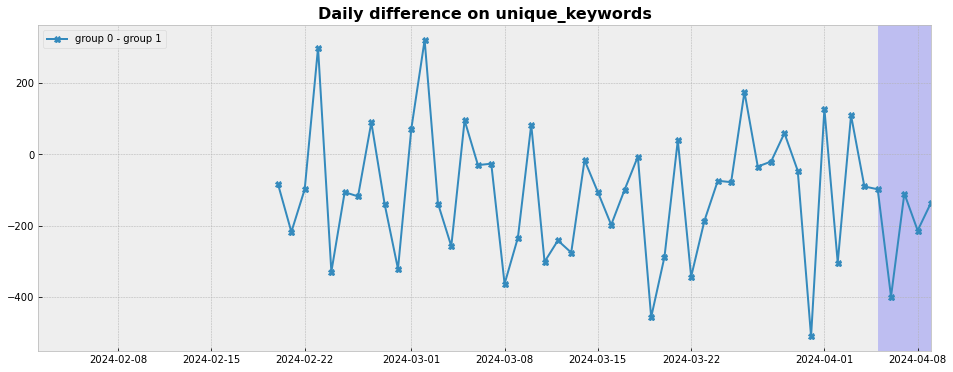

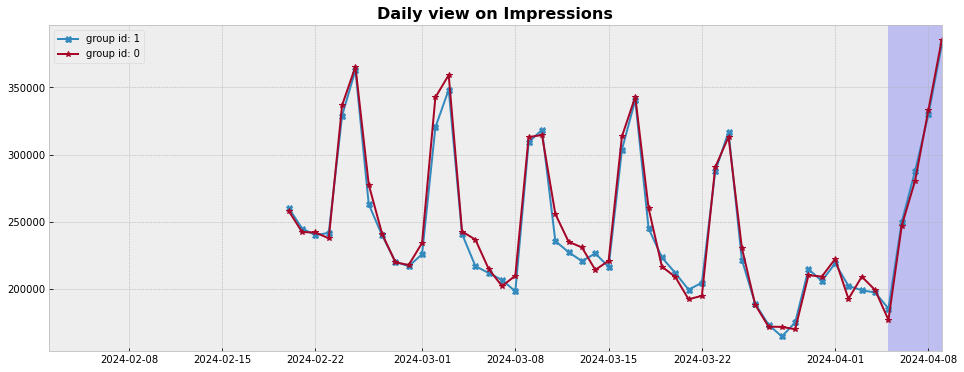

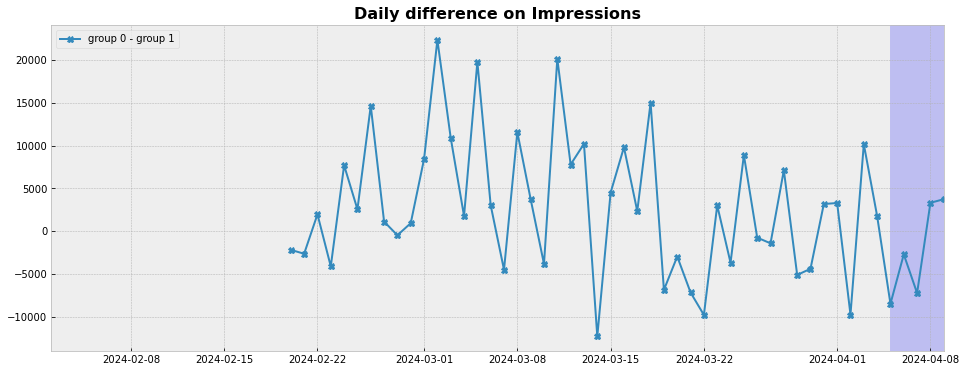

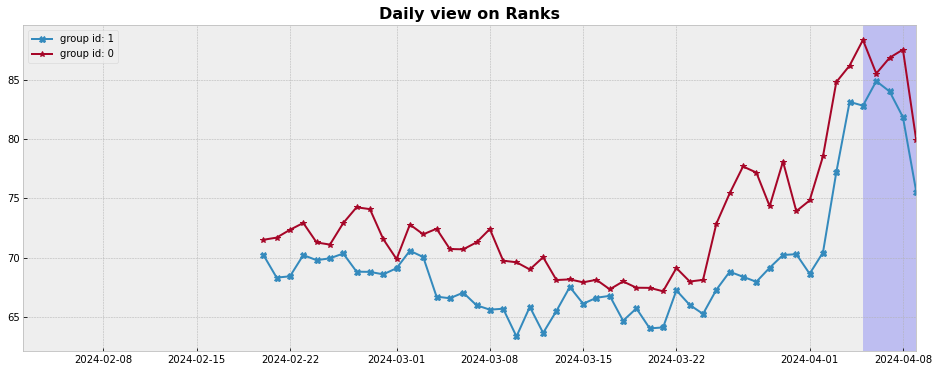

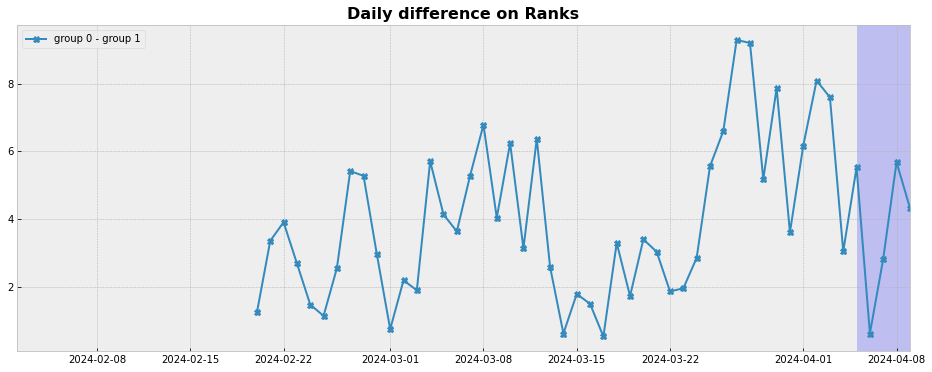

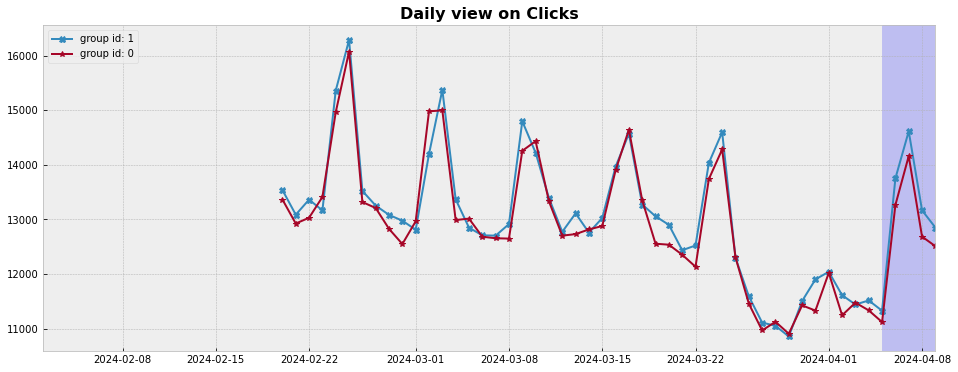

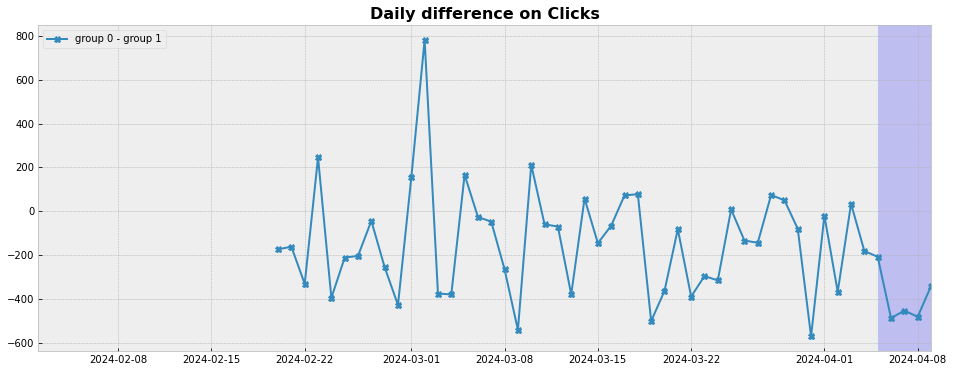

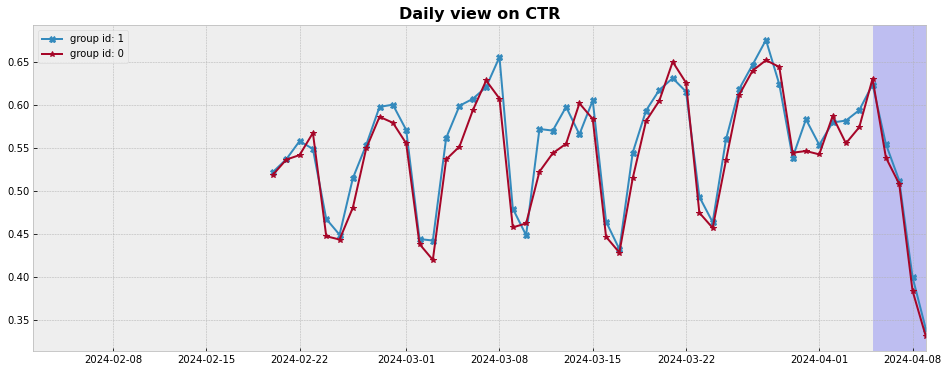

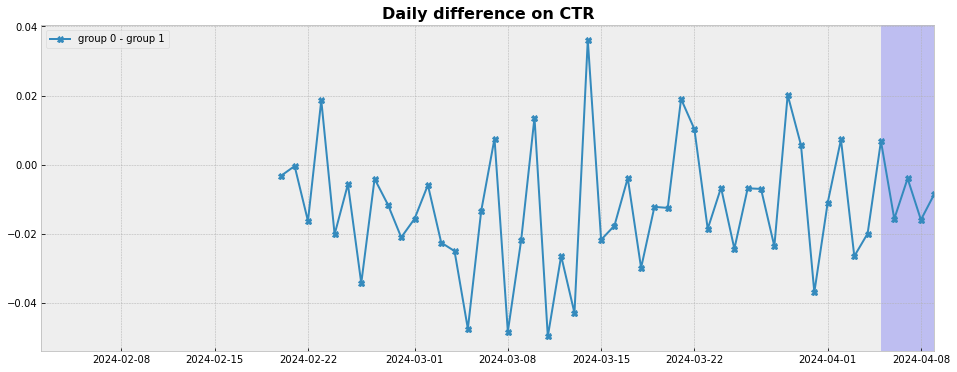

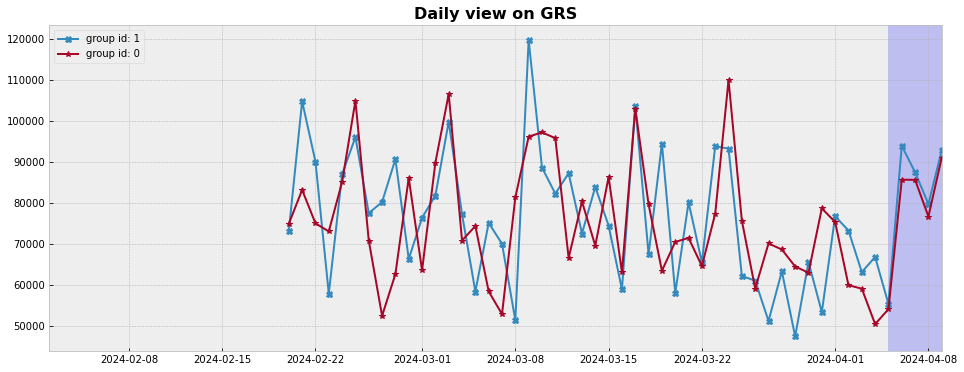

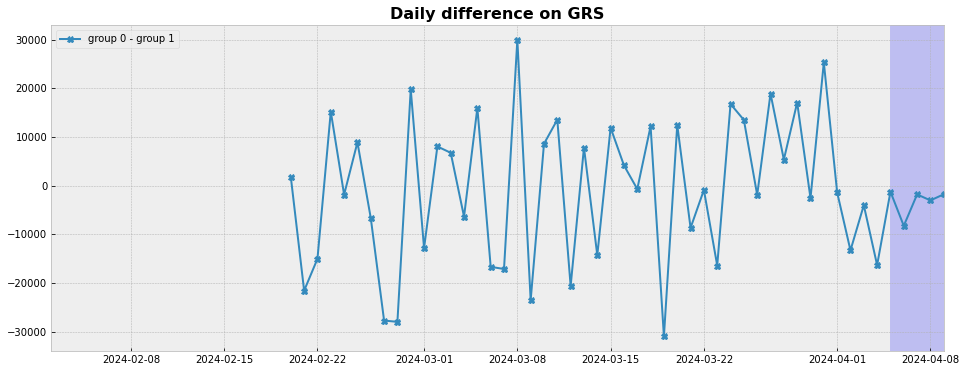

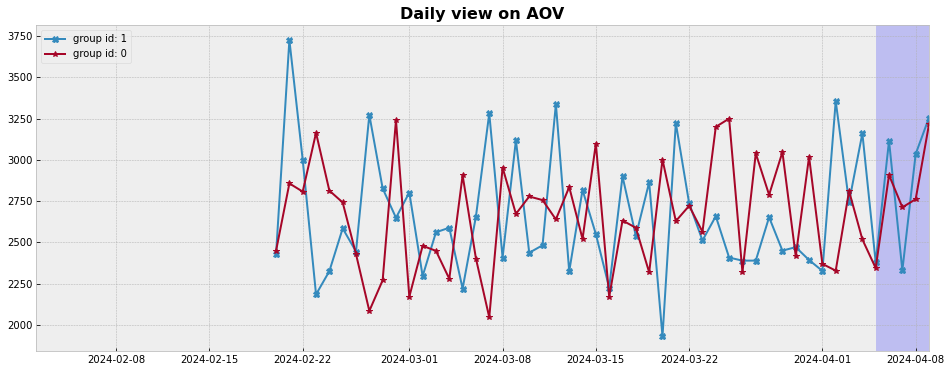

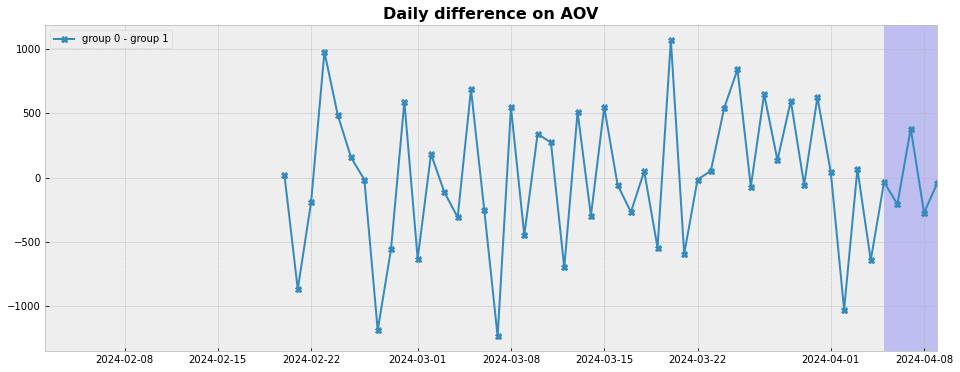

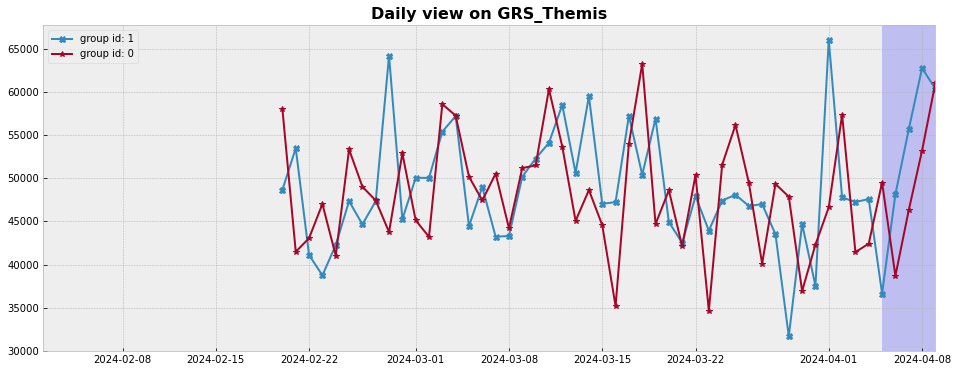

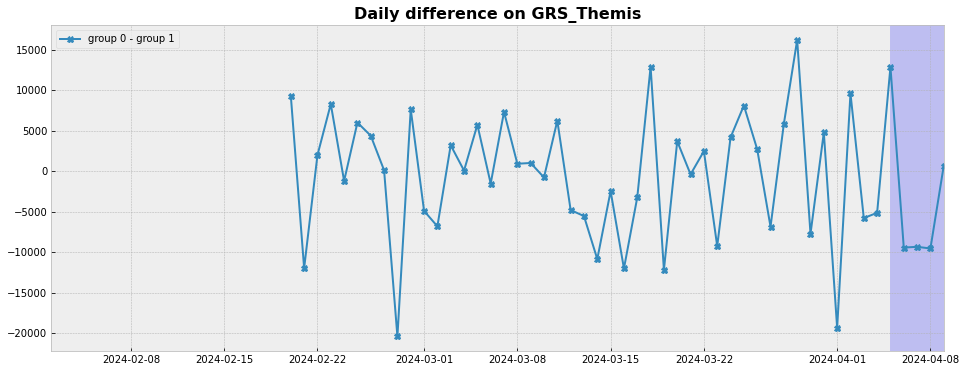

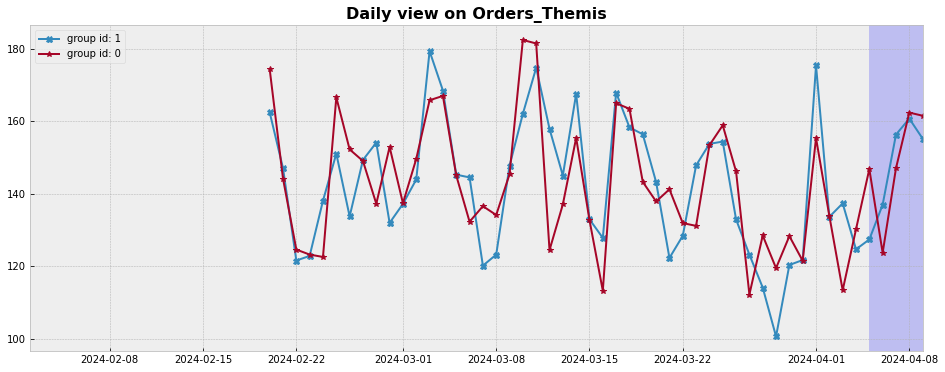

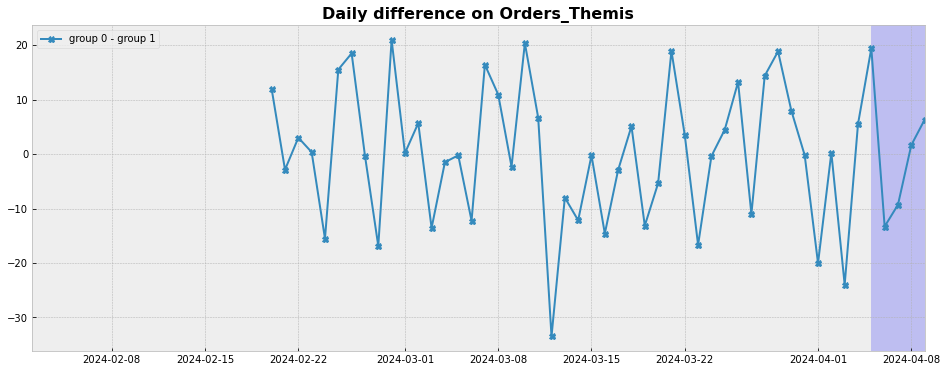

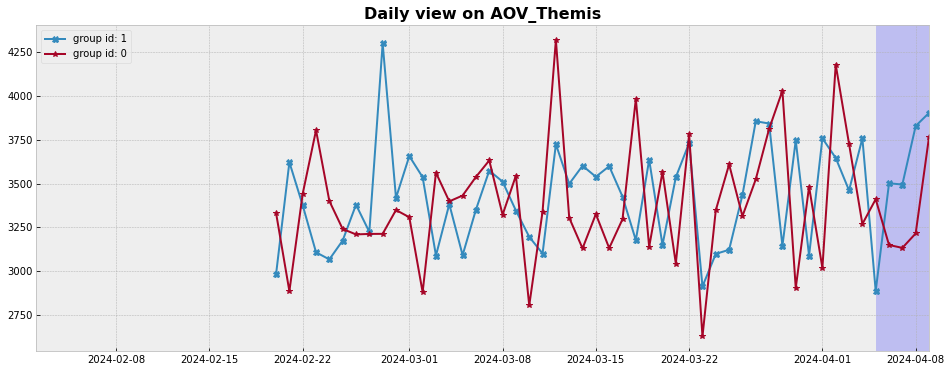

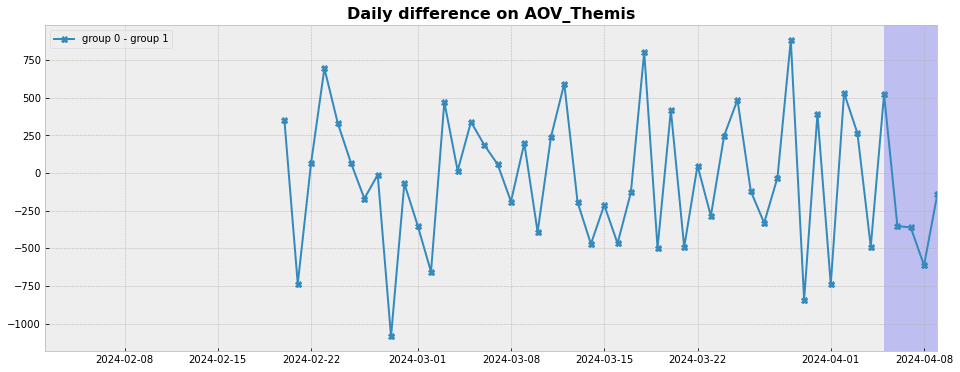

In [70]:
plot_comparisons(daily_data=measurement_df, 
                metrics = KPI_measurement_cols, 
                group_column = 'testgroup', 
                date_column = date_column_meas,
                group_ids=[1,0], 
                group_ratios=[0.5, 0.5], 
                time_range=[validation_start_date, test_end_date], 
                shade_window=[test_start_date, test_end_date], 
                include_diff=True)